In [1]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix, precision_score, recall_score, roc_curve, auc, classification_report

In [3]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 1
EPOCHS = 75

In [4]:
dataset = tf.keras.utils.image_dataset_from_directory(
    "TumorData",
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    color_mode="grayscale",
    shuffle=True,  
)


    

Found 5712 files belonging to 4 classes.


In [5]:
class_names = dataset.class_names
class_names

['glioma', 'meningioma', 'notumor', 'pituitary']

In [6]:
len(dataset) #shows the number of batchs for the whole dataset

179

In [7]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch[0].shape)
    

(256, 256, 1)


In [8]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 1)
[2 2 0 1 0 2 2 1 2 0 2 0 3 2 2 1 3 2 3 0 3 3 1 1 0 2 2 2 1 0 0 3]


In [9]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch[0])

tf.Tensor(
[[[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 ...

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]], shape=(256, 256, 1), dtype=float32)


In [10]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch[0].numpy())

[[[0. ]
  [0. ]
  [0. ]
  ...
  [0. ]
  [0. ]
  [0. ]]

 [[0. ]
  [0. ]
  [0. ]
  ...
  [0.5]
  [0.5]
  [0.5]]

 [[0. ]
  [0. ]
  [0. ]
  ...
  [2.5]
  [2.5]
  [2.5]]

 ...

 [[0. ]
  [0. ]
  [0. ]
  ...
  [2. ]
  [2. ]
  [2. ]]

 [[0. ]
  [0. ]
  [0. ]
  ...
  [1. ]
  [1. ]
  [1. ]]

 [[0. ]
  [0. ]
  [0. ]
  ...
  [1. ]
  [1. ]
  [1. ]]]


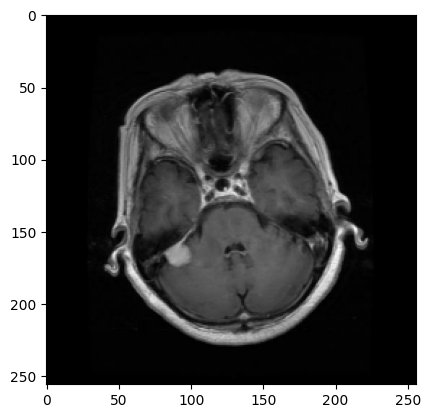

In [11]:
for image_batch, label_batch in dataset.take(1):
    plt.imshow(image_batch[0].numpy(), cmap='gray')
    
    

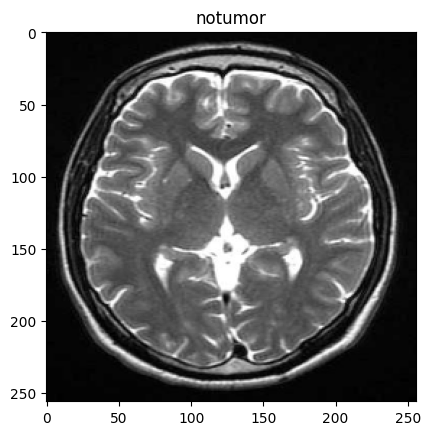

In [12]:
for image_batch, label_batch in dataset.take(1):
    plt.imshow(image_batch[0].numpy(), cmap='gray')
    plt.title(class_names[label_batch[0]])
    
    

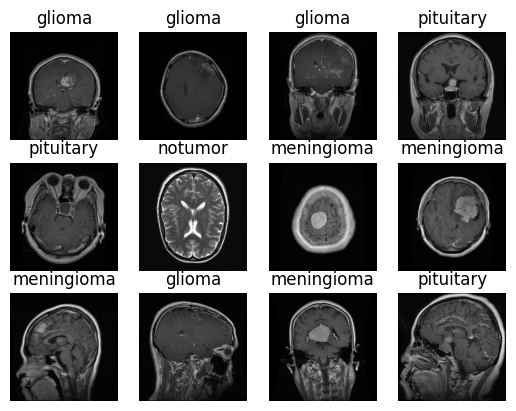

In [13]:
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax =plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy(), cmap='gray')
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

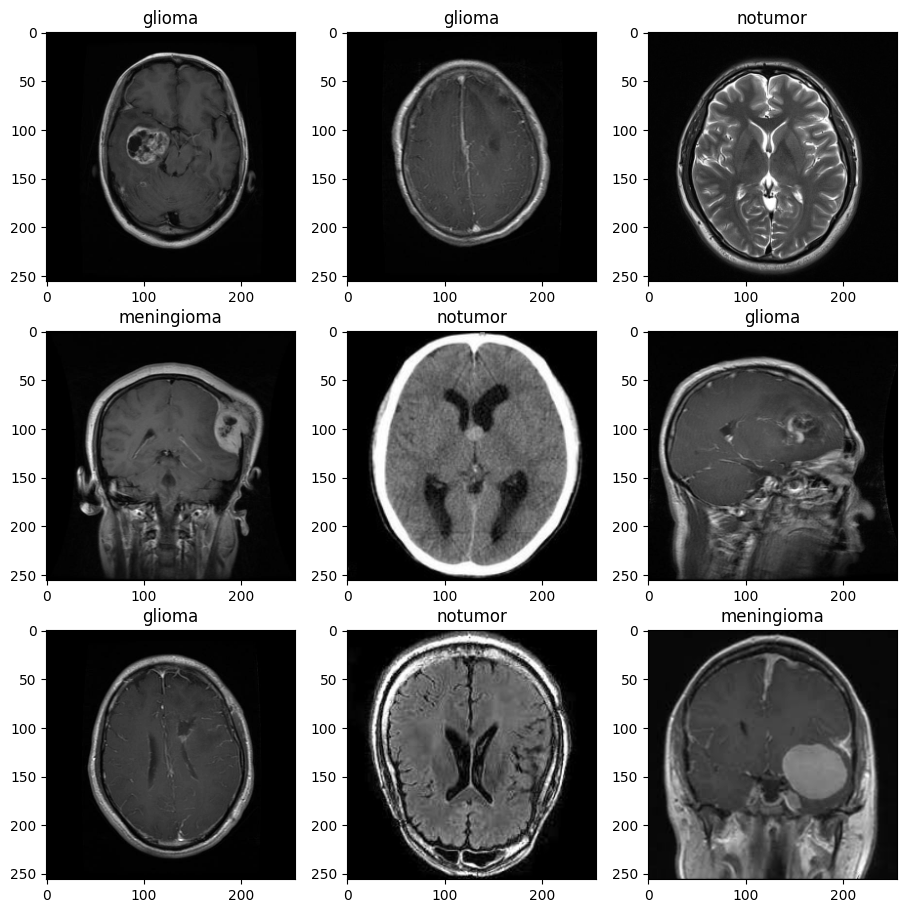

In [14]:
plt.figure(figsize=(11, 11))

for image_batch, label_batch in dataset.take(1):
    for i in range(9):
        ax =plt.subplot(3,3,i+1)  
        plt.imshow(image_batch[i].numpy(), cmap='gray')
        plt.title(class_names[label_batch[i]])
        

In [15]:
len(dataset)

179

In [16]:
training_percentage = 0.8
validation_percentage = 0.1
test_percentage = 0.1


In [17]:
train_size = 0.8
len(dataset) * train_size


143.20000000000002

In [18]:
train_ds = dataset.take(143)
len(train_ds)


143

In [19]:
test_ds = dataset.skip(143)
len(test_ds)

36

In [20]:
val_size = 0.1
len(dataset) * val_size

17.900000000000002

In [21]:
val_ds = dataset.take(17)
len(val_ds)

17

In [22]:
test_ds = test_ds.skip(17)
len(test_ds)

19

In [23]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle_size=1000):
    ds_size = len(ds)
    
    shuffle = True 
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
        
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)
    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [24]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [25]:
len(train_ds)

143

In [26]:
len(val_ds)

17

In [27]:
len(test_ds)

19

In [28]:
resize_and_rescale = tf.keras.Sequential( [
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
] )

In [29]:
data_augmentation = tf.keras.Sequential( [
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomTranslation(0.2, 0.2),
    layers.experimental.preprocessing.RandomZoom(0.2),
   
   
])

In [30]:
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 4

model = models.Sequential([
    layers.Conv2D(64, (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    
    layers.Flatten(),
    
    layers.Dense(16, activation='relu'),  # Changed from 32 to 24
    layers.Dropout(0.5),
    layers.Dense(16, activation='relu'),  # Changed from 32 to 24
    layers.Dropout(0.5),
    
    layers.Dense(n_classes, activation='softmax')
])


In [31]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 64)      640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 64)      

In [32]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)


In [ ]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

In [ ]:
score = model.evaluate(test_ds)
score = model.evaluate(train_ds)
score = model.evaluate(val_ds)

In [ ]:
model.save(r"C:\Users\User\Brain_Tumor\TumorData\75_new_model.h5")


In [ ]:
model.save_weights(r"C:\Users\User\Brain_Tumor\TumorData\75__new_model_weights.h5")


In [ ]:
history.history.keys()

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

In [ ]:

# Plot training and validation accuracy values
plt.figure(figsize=(11, 5))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

# Plot training and validation loss values
plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.show()

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)
    
    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence
    

In [ ]:
plt.figure(figsize=(13, 13))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"),cmap='gray')
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}).\n Confidence: {confidence}%")

        plt.axis("off")

In [ ]:
# Assuming test_ds is your test dataset
true_labels = []
predicted_classes = []

# Iterate through batches in the test dataset
for images, labels in test_ds:
    true_labels.extend(labels.numpy())  # Extract true labels
    predictions = model.predict(images)  # Assuming 'model' is your trained model
    predicted_classes.extend(np.argmax(predictions, axis=1))  # Extract predicted classes

# Convert the lists to NumPy arrays
true_labels = np.array(true_labels)
predicted_classes = np.array(predicted_classes)

# Ensure the lengths match
assert len(true_labels) == len(predicted_classes), "Lengths of true labels and predicted classes do not match."

# Print the classification report
print(classification_report(true_labels, predicted_classes))

In [ ]:

import seaborn as sns

# Assuming test_ds is your test dataset
true_labels = []
predicted_classes = []

# Iterate through all batches in the test dataset
for images, labels in test_ds:
    true_labels.extend(labels.numpy())  # Extract true labels
    predictions = model.predict(images)  # Assuming 'model' is your trained model
    predicted_classes.extend(np.argmax(predictions, axis=1))  # Extract predicted classes

# Convert the lists to NumPy arrays
true_labels = np.array(true_labels)
predicted_classes = np.array(predicted_classes)

# Ensure the lengths match
assert len(true_labels) == len(predicted_classes), "Lengths of true labels and predicted classes do not match."

# Generate confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_classes)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [ ]:
from sklearn.preprocessing import label_binarize

# Assuming test_ds is your test dataset
true_labels = []
predicted_probs = []

# Iterate through batches in the test dataset
for images, labels in test_ds:
    true_labels.extend(labels.numpy())  # Extract true labels
    predictions = model.predict(images)  # Assuming 'model' is your trained model
    predicted_probs.extend(tf.nn.softmax(predictions, axis=-1).numpy())  # Extract predicted probabilities

# Convert the lists to NumPy arrays
true_labels = np.array(true_labels)
predicted_probs = np.array(predicted_probs)

# Ensure the lengths match
assert len(true_labels) == len(predicted_probs), "Lengths of true labels and predicted probabilities do not match."

# Convert true_labels to one-hot encoded format
n_classes = 4
true_labels_onehot = label_binarize(true_labels, classes=[0, 1, 2, 3])

# Plot all ROC curves in the same plot
plt.figure(figsize=(8, 6))

for i in range(n_classes):
    fpr, tpr, _ = roc_curve(true_labels_onehot[:, i], predicted_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for All Classes')
plt.legend()
plt.show()


In [ ]:
from sklearn.metrics import precision_recall_curve, auc

# Plot all precision-recall curves in the same plot
plt.figure(figsize=(8, 6))

for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(true_labels_onehot[:, i], predicted_probs[:, i])
    pr_auc = auc(recall, precision)
    plt.plot(recall, precision, label=f'Class {i} (AUC = {pr_auc:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for All Classes')
plt.legend()
plt.show()